# 목표
머신러닝을 이용하여, 이러한 부정거래를 탐지해 보고자 합니다. 하지만, 지도학습이 아닌 비지도 학습을 이용합니다. 그 중 이상 탐지(Outlier Detection) 알고리즘을 이용하여 라벨을 통한 학습이 아닌 이상치 데이터 집단을 찾아 그 이상치 집단이 부정거래 데이터와 일치 및 유사한지 알아볼 것입니다.

# 01.1. 신용카드 데이터 셋
데이터 셋의 경우 kaggle에서 제공하는 Credit Card Fraud Detection Dataset을 이용하였습니다.
위 데이터 셋은 2013년 9월 유럽의 실제 신용 카드 거래 데이터를 담고 있습니다. 데이터는 총 284,807건이며 그 중 492건만이 부정 거래 데이터 입니다.
즉, 데이터가 매우 불균형(imbalanced) 합니다.

In [53]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [55]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# model 관련

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# 다른 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import  KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [16]:
df = pd.read_csv('../82106/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


위 데이터 셋은 개인정보 비식별화처리로 인해 칼럼정보를 알 수 없으며, 데이터 또한 스케일(scale) 및 PCA(principal component analysis) 처리 되어있습니다.
총 31개의 칼럼으로 이루어져 있고, Time, Amount, Class를 제외한 모든 칼럼은 비식별화처리 되어있습니다.

In [17]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

데이터는 총 284,807건이며 null값은 존재하지 않는 정형 데이터 입니다.

# 2. 데이터 탐색(EDA)
시간(Time)대별 정상/부정 거래 비율

In [18]:
import matplotlib.pyplot as plt

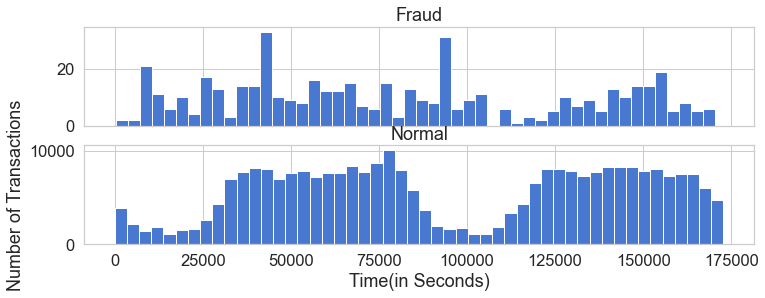

In [19]:
# 시간대별 트랜잭션 양
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,4))
ax1.hist(df.Time[df.Class==1], bins=50)
ax2.hist(df.Time[df.Class==0], bins=50)

ax1.set_title('Fraud')
ax2.set_title('Normal')
plt.xlabel('Time(in Seconds)'); plt.ylabel('Number of Transactions')
plt.show()

대체적으로 정상 거래의 경우 시간에 따라 주기적인 반면 부정 거래의 경우 불규칙한 특성을 보입니다.

금액(Amount)대별 정상/부정 거래 비율

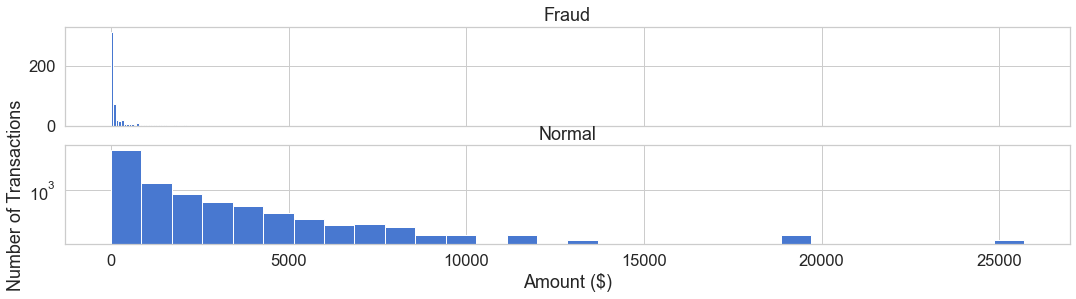

In [29]:
# 금액대별 트랜잭션 양
f, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(18,4))
ax1.hist(df.Amount[df.Class==1], bins=30)
ax2.hist(df.Amount[df.Class==0], bins=30)
ax1.set_title('Fraud')
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

정상 거래의 경우 다양한 금액대에서 발생되지만, 부정 거래의 경우 적은 금액에서 주로 발생하는 것 같습니다.

비식별칼럼 정상/부정거래 비율 표시.

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 정상/비정산 럼간 값 분포
v_features = df.iloc[:,1:29].columns


C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


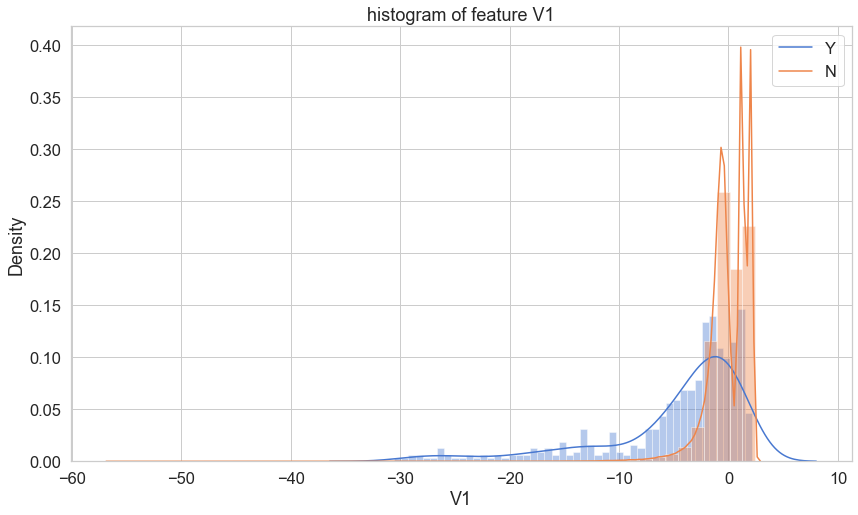

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


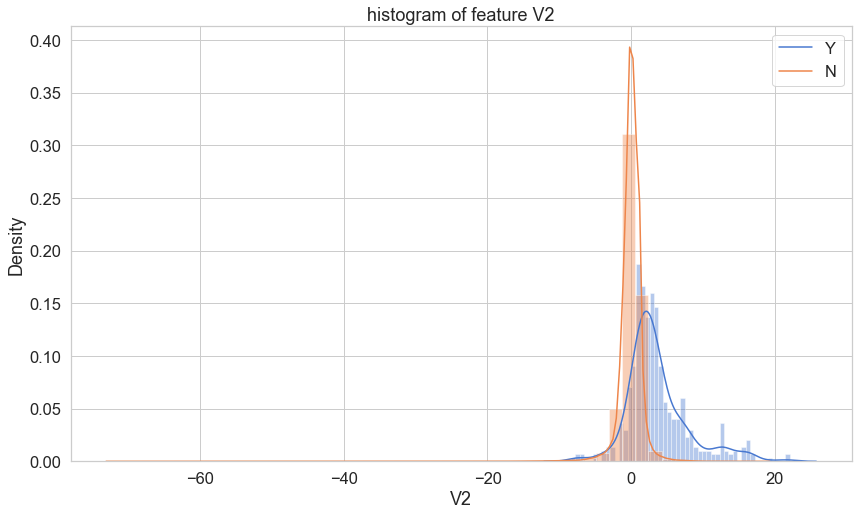

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


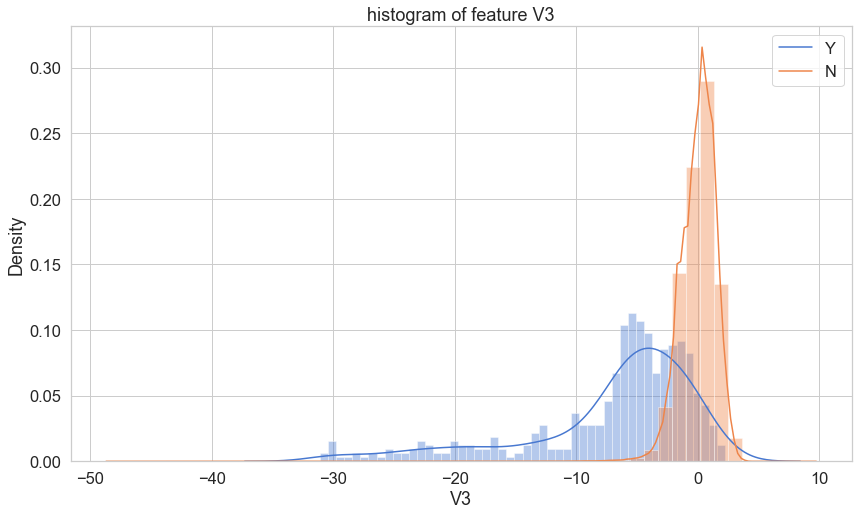

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


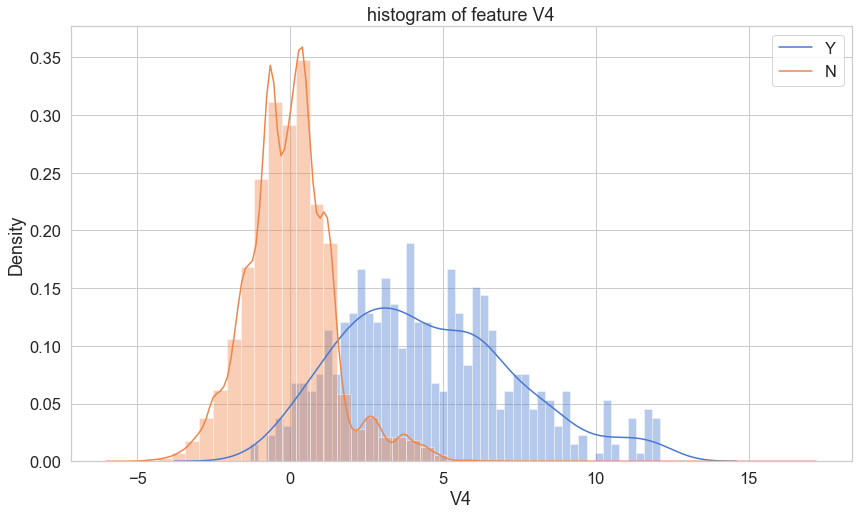

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


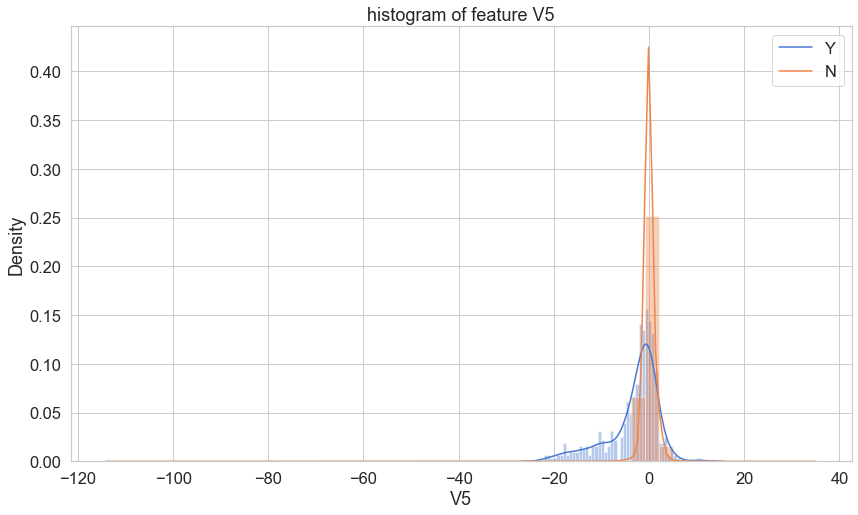

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


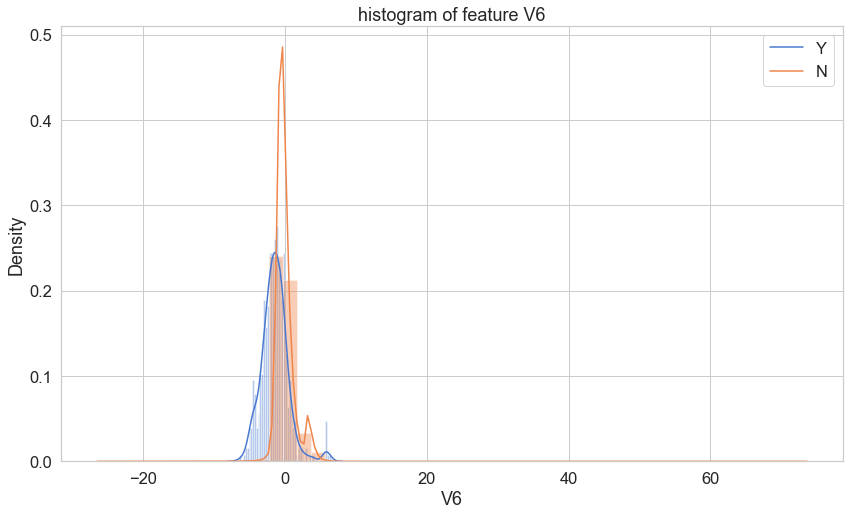

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


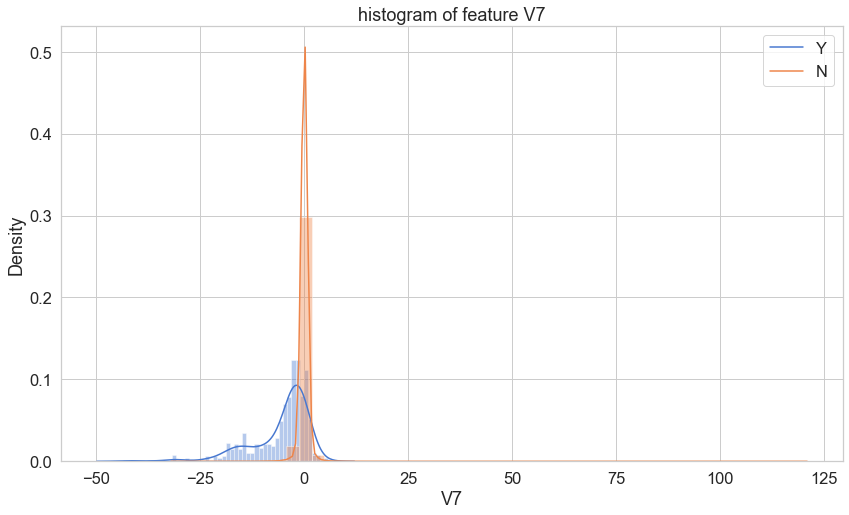

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


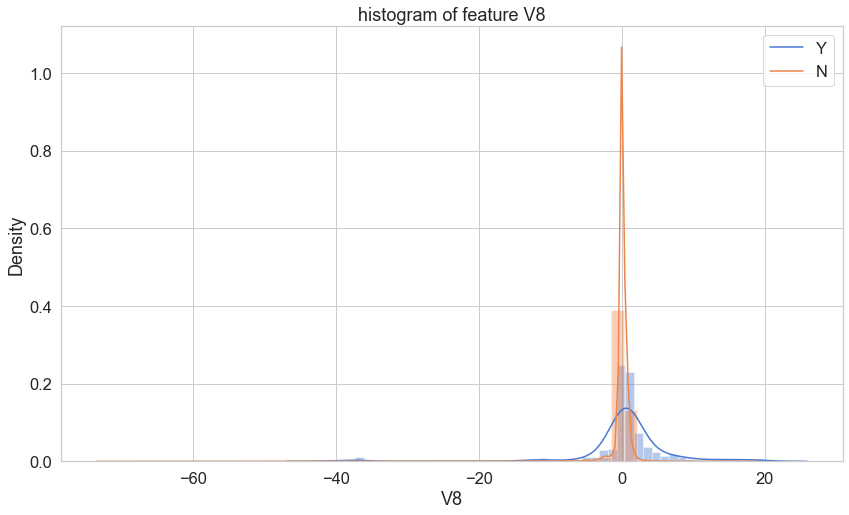

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


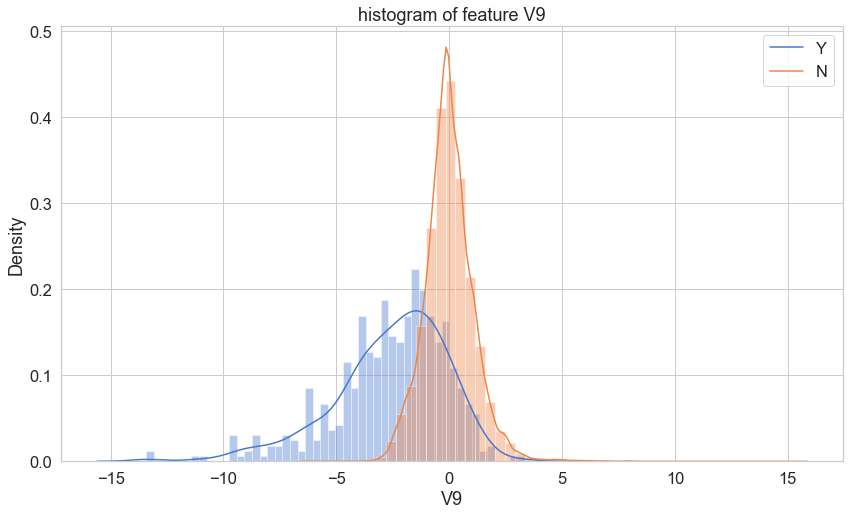

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


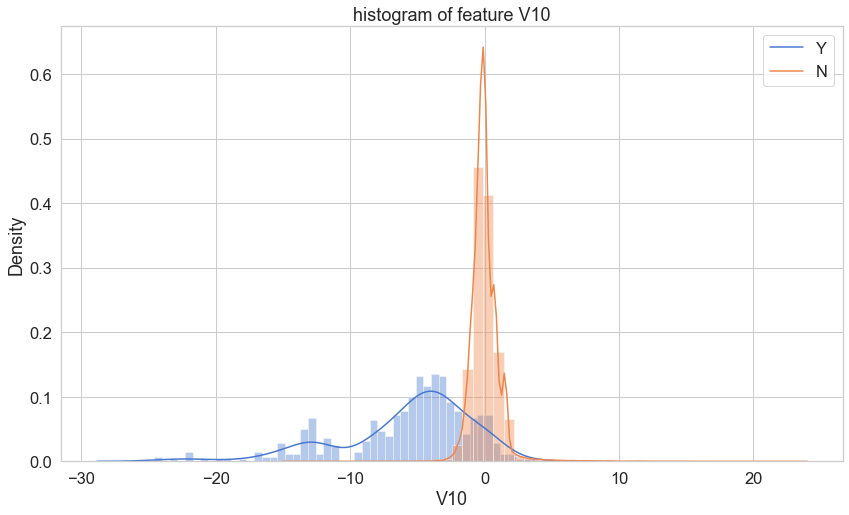

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


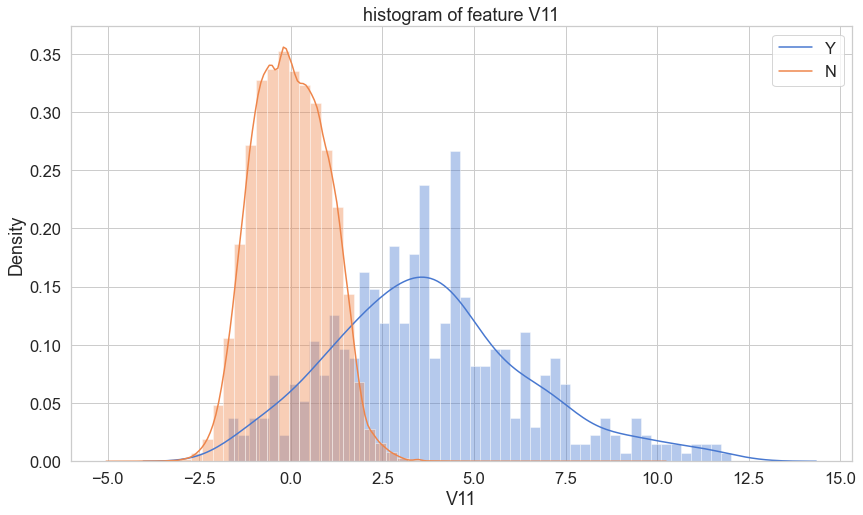

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


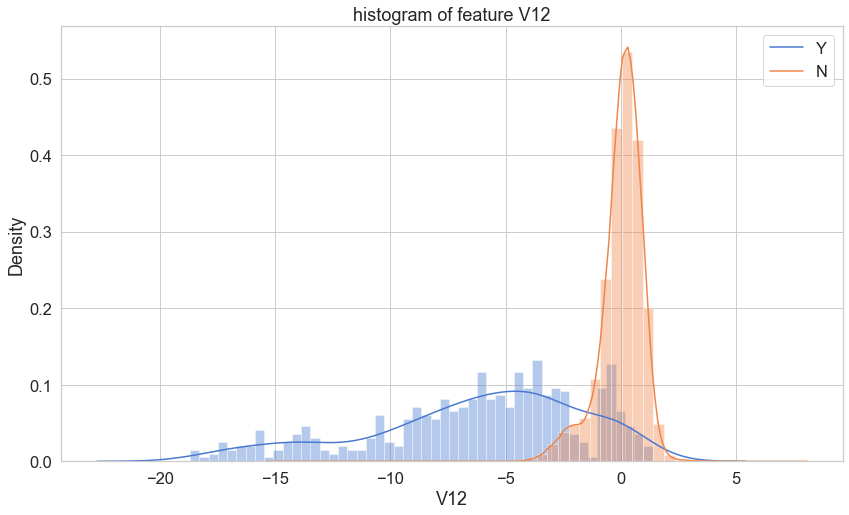

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


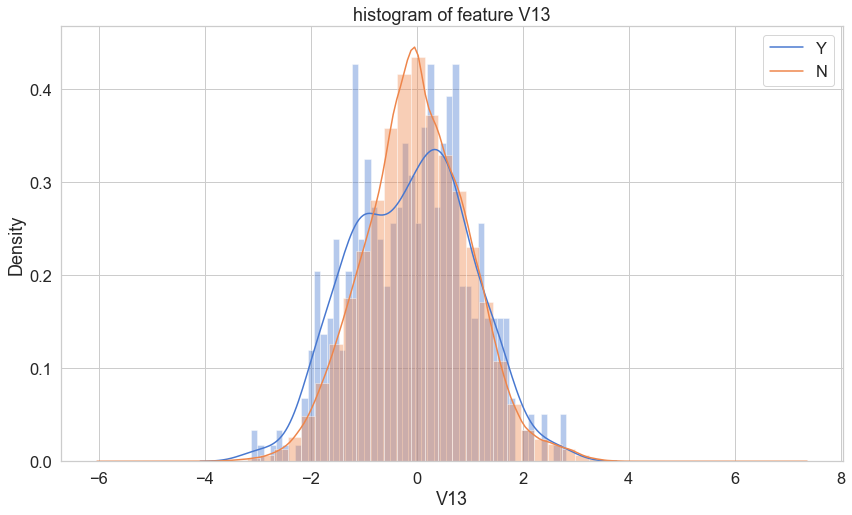

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


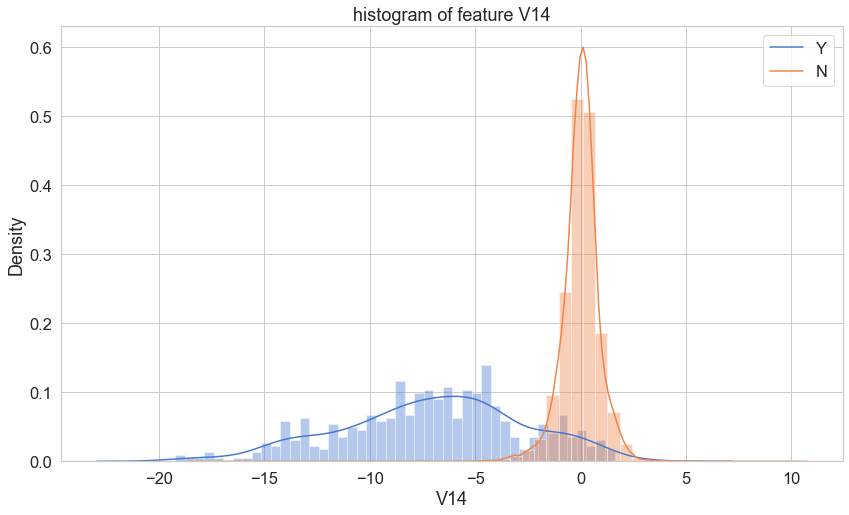

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


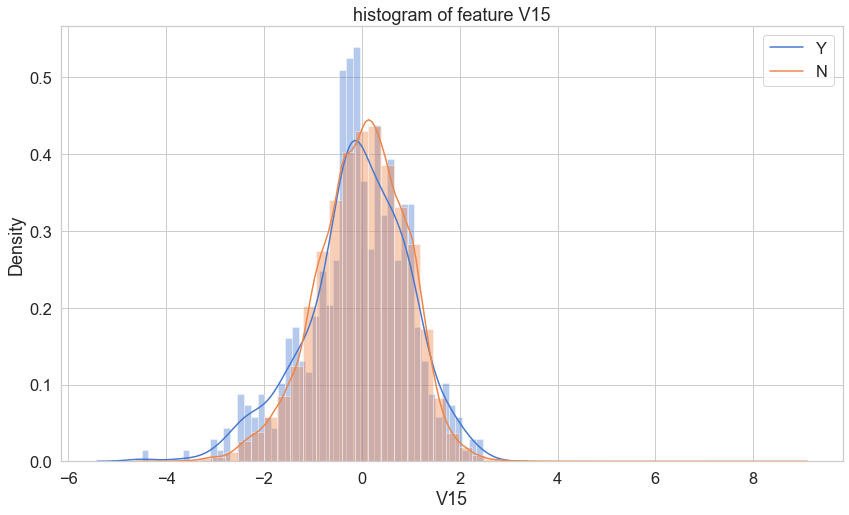

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


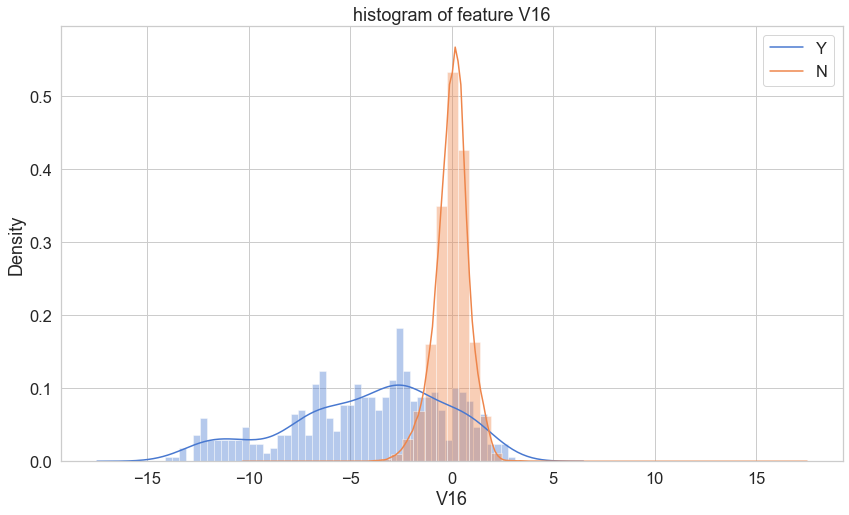

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


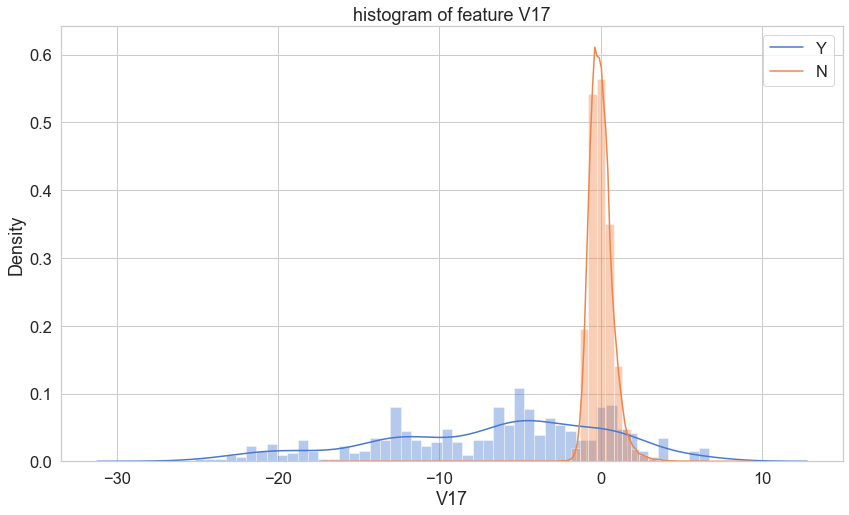

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


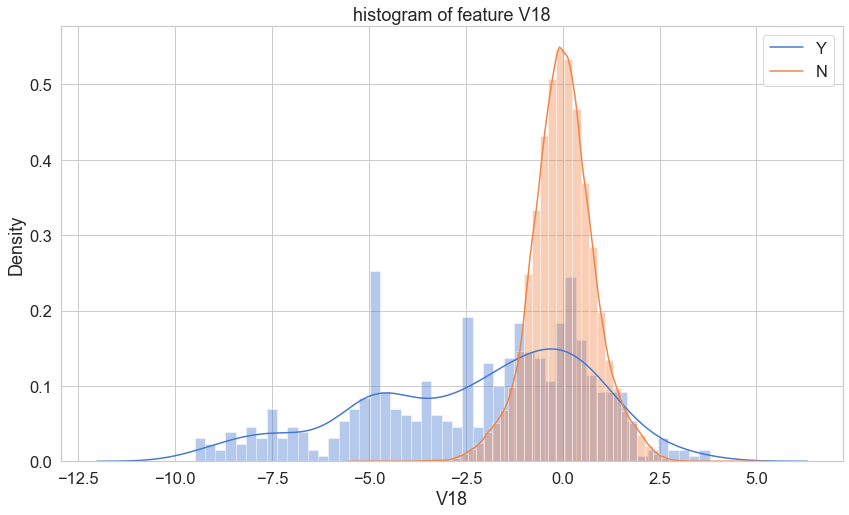

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


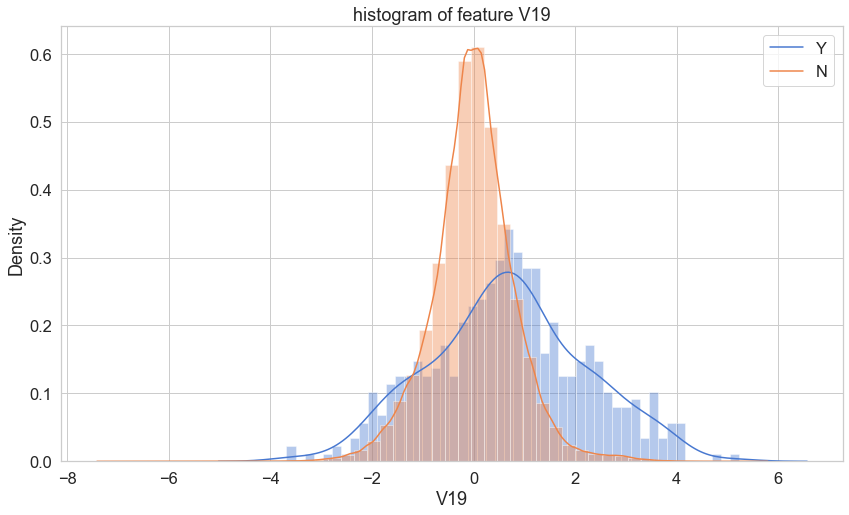

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


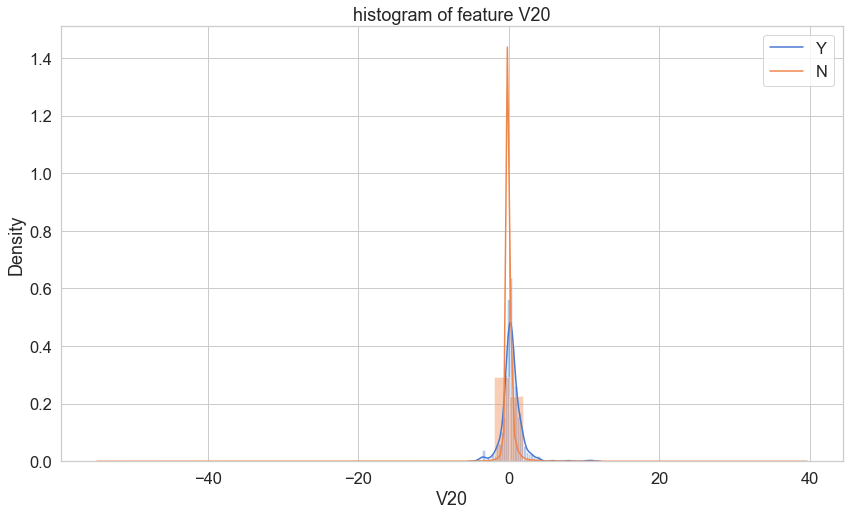

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


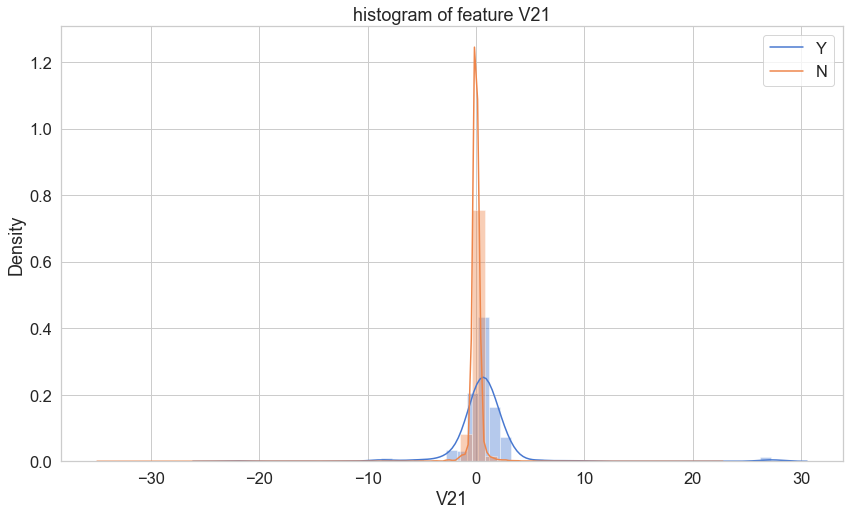

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


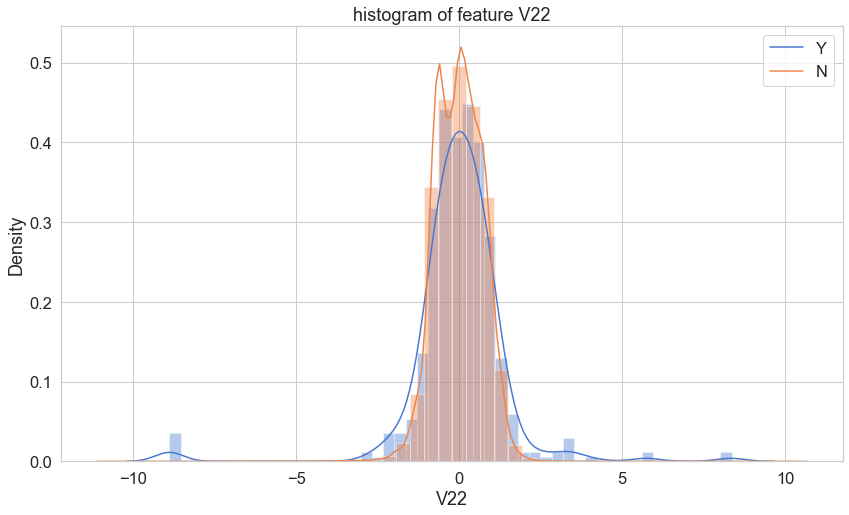

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


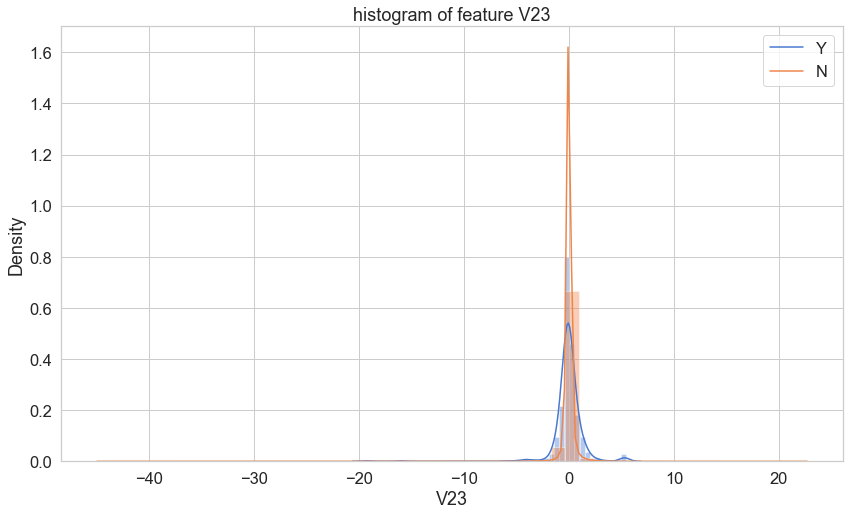

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


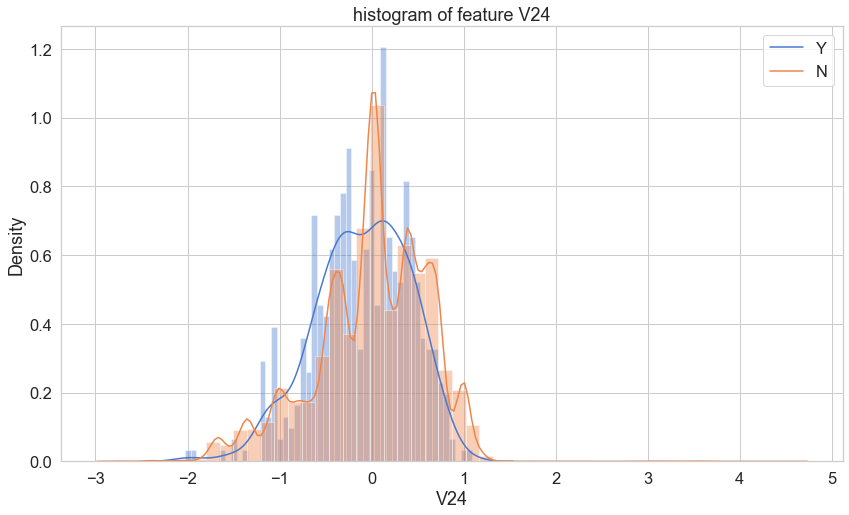

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


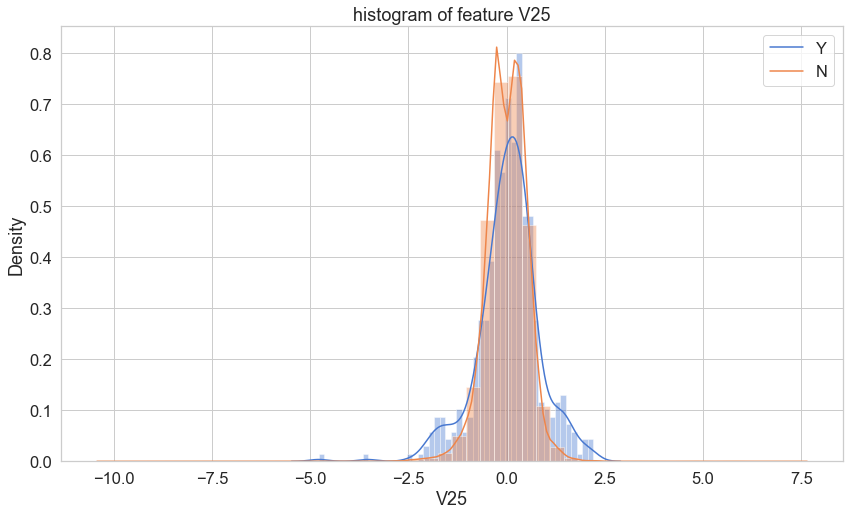

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


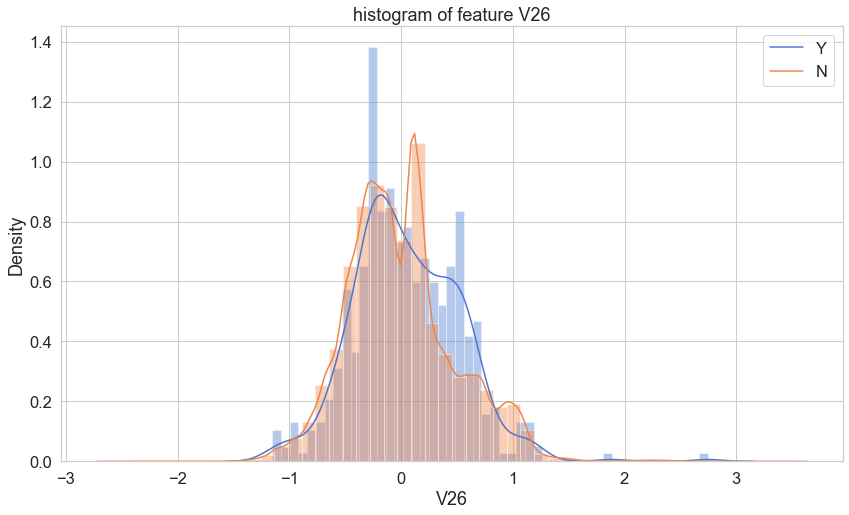

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


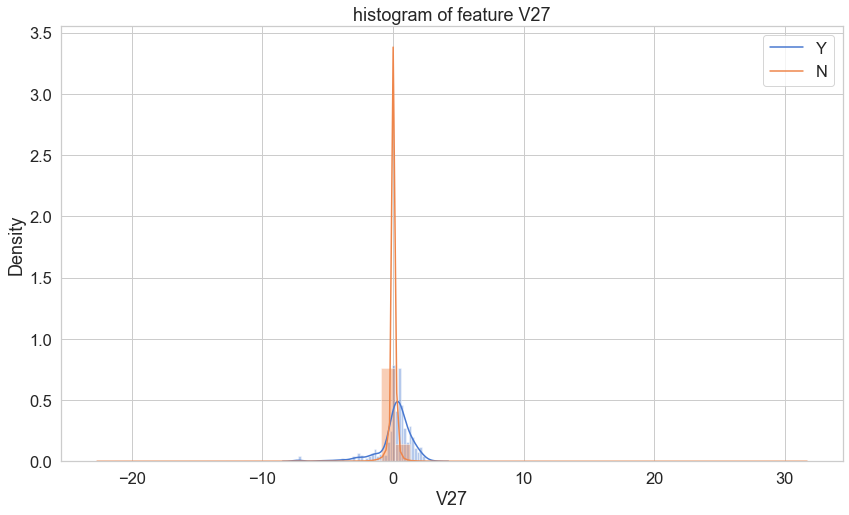

C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\82106\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


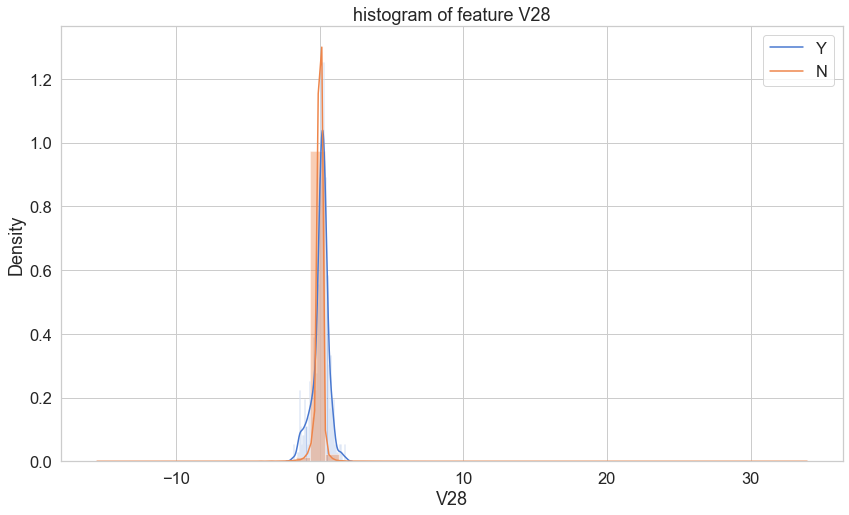

In [41]:
for cnt, col in enumerate(df[v_features]):
    sns.distplot(df[col][df.Class==1], bins=50)
    sns.distplot(df[col][df.Class==0], bins=50)
    plt.legend(['Y','N'], loc='best')
    plt.title('histogram of feature '+str(col))
    plt.show()

# 3. Isolation Forest
이상탐지 알고리즘으로는 Isolation Forest 알고리즘을 이용하였습니다. Isolation Forest 는 Tree 기반으로 데이터를 나누어 데이터의 관측치를 고립시키는 알고리즘입니다. 이상 데이터의 경우 root node와 가까운 depth를 가지고, 정상 데이터의 경우 tree의 말단 노드에 가까운 depth를 가집니다.

# 4. 이상 탐지 알고리즘 적용
Isolation Forest 알고리즘은 현재 scikit-learn에서 제공되고 있으며, 링크를 통해 다큐먼트를 확인할 수 있습니다.
Isolation Forest는 이상치 점수(outlier score)를 제공합니다.

# Python
학습에 사용되는 모델은 텐서플로우 하이레벨 API인 tf.layers와 Estimator를 이용해서 구현한다.

하이레벨 API를 사용하는 이유는 http://bcho.tistory.com/1195 http://bcho.tistory.com/1196 에서도 설명했듯이 구현이 상대적으로 쉬울뿐더러, 분산 학습이 가능하기 때문

데이터 입력 부분은 tfrecord 파일을 읽어서, 파일 큐를 생성해서 input_fn 을 생성하는 부분이다. 이렇게 생성된 input_fn 함수는 Estimator 를 통해서, 학습과 테스트(검증) 데이터로 피딩되게 된다.

데이터 입력 부분은 read_and_decode함수와 input_fn 함수로 구현

In [58]:
def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image_raw':tf.FixedLenFeature([],tf.string),
            'label':tf.FixedLenFeature([],tf.int64),
        })
    
    image = tf.decode_raw(features['image_raw'],tf.uint8)
    image.set_shape([784]) #image shape is (784,)
    image = tf.cast(image,tf.float32)*(1.0/255)
    label = tf.cast(features['label'],tf.int32)
    
    return image,label


ead_and_decode 함수는 filename_queue에서, 파일을 읽어서 순서대로 TFRecoderReader를 읽어서 파싱한후에, image_raw이름으로 된 피쳐와,  label로 된 피쳐를 읽어서 각각 image와 label 이라는 텐서에 저장한다.

image는 차원을 맞추기 위해서 set_shape를 이용하여 1차원으로 784의 길이를 가진 텐서로 변환하고, 학습에 적절하도록 데이타를 regulization 을 하기 위해서, 1.0/255 를 곱해줘서 1~255값의 칼라값을 0~1사이의 값으로 변환한다.

그리고 label값은 0~9를 나타내는 숫자 라벨이기 때문에, tf.int32로 형 변환을 한다.

변환이 끝난 image와 label 텐서를 리턴한다. 

In [60]:
def input_fn(filename,batch_size=100):
    filename_queue = tf.train.string_input_producer([filename])
    
    image,label = read_and_decode(filename_queue)
    images,labels = tf.train.batch(
        [image,label],batch_size=batch_size,
        capacity=1000+3*batch_size)
    #images : (100,784), labels : (100,1)
    
    return {'inputs':images},labels

Input_fn 함수는 실제로 Estimator에 값을 피딩하는 함수로, 입력 받은 filename으로 파일이름 큐를 만들어서 read_and_decode 함수에 전달 한 후, image와 label 값을 리턴받는다.

리턴 받은 값을 바로 리턴하지 않고 배치 학습을 위해서 tf.train.batch를 이용하여 배치 사이즈(batch_size)만큼 묶어서 리턴한다. 

# 모델 구현
아래는 모델을 구현한 autoecndoer_model_fn 함수이다.

Custom Estimator를 구현하기 위해서 사용한 구조

In [62]:
def autoencoder_model_fn(features,labels,mode): #오토인코더 네트워크 구현
    input_layer = features['inputs']
    dense1 = tf.layers.dense(inputs=input_layer,units=256,activation=tf.nn.relu)
    dense2 = tf.layers.dense(inputs=dense1,units=128,activation=tf.nn.relu)
    dense3 = tf.layers.dense(inputs=dense2,units=16,activation=tf.nn.relu)
    dense4 = tf.layers.dense(inputs=dense3,units=128,activation=tf.nn.relu)
    dense5 = tf.layers.dense(inputs=dense4,units=256,activation=tf.nn.relu)
    output_layer = tf.layers.dense(inputs=dense5,units=784,activation=tf.nn.sigmoid)
    
    #training and evaluation mode
    if mode in (Modes.TRAIN,Modes.EVAL):
        global_step = tf.contrib.framework.get_or_create_global_step()
        label_indices = tf.cast(labels,tf.int32)
        loss = tf.reduce_sum(tf.square(output_layer - input_layer))
        tf.summary.scalar('OptimizeLoss',loss)

        if mode == Modes.TRAIN:
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            train_op = optimizer.minimize(loss,global_step=global_step)
            return tf.estimator.EstimatorSpec(mode,loss = loss, train_op = train_op)
        if mode == Modes.EVAL:
            eval_metric_ops = None
            return tf.estimator.EstimatorSpec(
                mode,loss=loss,eval_metric_ops = eval_metric_ops)
        
    # prediction mode
    if mode == Modes.PREDICT:
        predictions={
            'outputs':output_layer
        }
        export_outputs={
            'outputs':tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,predictions=predictions,export_outputs=export_outputs) #이부분 코드 상세 조사할것


input_fn에서 피딩 받은 데이터를 input_layer로 받아서, 각 256,128,16,128,,256의 노드로 되어 있는  5개의 네트워크를 통과한 후에, 최종적으로 784의 아웃풋과  sigmoid 함수를 활성화(activation function)으로 가지는 output layer를 거쳐서 나온다.
 
 다음 모델의 모드 즉 학습, 평가, 그리고 예측 모드에 따라서 loss 함수나 train_op 등이 다르게 정해진다.

학습과 테스트 모드일 경우, global_step을 정하고, loss 함수를 정의한다.

학습 모드일 경우에는 아래와 같이 옵티마이저를 정하고,이 옵티마이저를 이용하여 loss 값을 최적화 하도록 하는 train_op를 정의해서 EstimatorSpec을 만들어서 리턴하였다.

테스트 모드 일 경우에는 옵티마이즈할 필요가 없기 때문에, 옵티마이져를 정의하지 않고 loss 값을 리턴하고, 평가를 위한 Evalutaion metrics를 정해서 리턴한다. 아래 코드는 별도로 evaluation metrics 를 정의하지 않고, 디폴트 메트릭스를 사용하였다.

예측 모드일 경우에는 loss 값이나 optimizer 등의 정의가 필요 없고, output값을 어떤 값을 내보낼지만 정의하면 되고, 예측 모델 (prediction model)을 프로토콜 버퍼 포맷으로 export 할때의 구조를 정의하기 위해서 export_outpus 부분만 아래와 같이 정의해주면 된다.

# Estimator 생성
모델에 대한 정의가 끝났으면, Estimator를 생성하는데, Estimator 정의는 아래와 같이 앞에서 정의한 모델인 autoencoder_model_fn을 정의해주고 


In [64]:
def build_estimator(model_dir):
    return tf.estimator.Estimator(
        model_fn = autoencoder_model_fn,
        model_dir = model_dir,
        config=tf.contrib.learn.RunConfig(save_checkpoints_secs=180))

# 실험 (Experiment) 구현
앞에서 구현된 Estimator를 이용하여, 학습과 테스트를 진행할 수 있는데, 직접 Estimator를 불러사용하는 방법 이외에 Experiment 라는 클래스를 사용하면, 이 부분을 단순화 할 수 있다. 

Experiment에는 사용하고자 하는  Estimator와 학습과 테스트용 데이터 셋, 그리고 export 전략 및, 학습,테스트 스탭을 넣어주면 자동으로 Estimator를 이용하여 학습과 테스트를 진행해준다.

아래는 Experiment 를 구현한 예이다. 

In [65]:
def generate_experiment_fn(data_dir,
                          train_batch_size = 100,
                          eval_batch_size = 100,
                          train_steps = 1000,
                          eval_steps = 1,
                          **experiment_args):
    def _experiment_fn(output_dir):
        return Experiment(
            build_estimator(output_dir),
            train_input_fn=get_input_fn('./data/train.tfrecords',batch_size=train_batch_size),
            eval_input_fn=get_input_fn('./data/test.tfrecords',batch_size=eval_batch_size),
            export_strategies = [saved_model_export_utils.make_export_strategy(
                serving_input_fn,
                default_output_alternative_key=None,
                exports_to_keep=1)
            ],
            train_steps = train_steps,
            eval_steps = eval_steps,
            **experiment_args
        )
    return _experiment_fn




learn_runner.run(
    generate_experiment_fn(
        data_dir='./data/',
        train_steps=2000),
    OUTDIR)

NameError: name 'learn_runner' is not defined